### The German Traffic Sign Benchmark

Student Name 1: Alberto Miño

Student Name 2: Adrian Michelena

In [ ]:
# Download the data base
# !wget -c http://www.dia.fi.upm.es/~lbaumela/FullIJCNN2013.zip
# !unzip FullIJCNN2013.zip
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

# drivePrefix = "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P4/dataset/"
!unzip -qq -u "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P4/dataset/FullIJCNN2013.zip"

Mounted at /gdrive


In [ ]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'], color="dodgerblue")
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'], color="green")
    axs[0].set_ylim(0, 1)
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1,step=len(model_history.history['accuracy'])/10))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'], color="darkorange")
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'], color="red")
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1,step=len(model_history.history['loss'])/10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

In [ ]:
import numpy as np
import cv2
import pandas as pd

IMG_HEIGHT = 600
SIGN_SIZE = (224, 224)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [ ]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

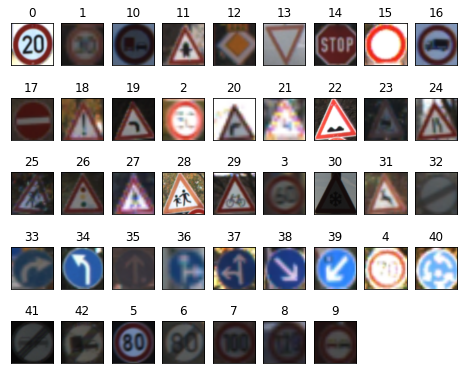

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

In [ ]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

### Assignment 1: Multi-Layer Perceptron

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras import optimizers
from keras.callbacks import EarlyStopping

learning_rate=0.001
epochs=1000
batch_size=128
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=int(epochs*0.2) )
p_dropout=0.1

# mlp.add(Dense(500, activation="relu", kernel_initializer="he_normal"))

mlp = Sequential()
mlp.add(Flatten(input_shape=(SIGN_SIZE[0], SIGN_SIZE[1], 3)))
mlp.add(Dense(150, activation="relu"))
mlp.add(Dropout(rate=p_dropout))
mlp.add(Dense(150, activation="relu"))
mlp.add(Dropout(rate=p_dropout))
mlp.add(Dense(150, activation="relu"))
mlp.add(Dropout(rate=p_dropout))
mlp.add(Dense(100, activation="relu"))
mlp.add(Dropout(rate=p_dropout))
mlp.add(Dense(num_classes, activation='softmax'))

opt = optimizers.SGD(lr=learning_rate, momentum=0.9, nesterov=True)
# opt = optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999)


mlp.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
mlp.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 150)               22579350  
_________________________________________________________________
dropout (Dropout)            (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_1 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               22650     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0

In [ ]:
start = time()
data = mlp.fit(tr_signs, tr_labels, batch_size=batch_size, epochs=epochs, verbose=2, validation_data=(va_signs, va_labels), callbacks=[tensorboard, es])
end = time()

Epoch 1/1000
5/5 - 3s - loss: 3.6916 - accuracy: 0.0483 - val_loss: 3.6427 - val_accuracy: 0.0992
Epoch 2/1000
5/5 - 2s - loss: 3.6188 - accuracy: 0.0950 - val_loss: 3.5246 - val_accuracy: 0.1548
Epoch 3/1000
5/5 - 2s - loss: 3.5545 - accuracy: 0.1100 - val_loss: 3.4564 - val_accuracy: 0.2063
Epoch 4/1000
5/5 - 2s - loss: 3.4842 - accuracy: 0.1200 - val_loss: 3.3723 - val_accuracy: 0.2024
Epoch 5/1000
5/5 - 2s - loss: 3.4017 - accuracy: 0.1667 - val_loss: 3.3131 - val_accuracy: 0.2460
Epoch 6/1000
5/5 - 2s - loss: 3.3556 - accuracy: 0.1767 - val_loss: 3.2787 - val_accuracy: 0.2341
Epoch 7/1000
5/5 - 2s - loss: 3.2673 - accuracy: 0.2000 - val_loss: 3.1950 - val_accuracy: 0.2540
Epoch 8/1000
5/5 - 2s - loss: 3.2345 - accuracy: 0.2117 - val_loss: 3.1433 - val_accuracy: 0.2540
Epoch 9/1000
5/5 - 2s - loss: 3.1192 - accuracy: 0.2317 - val_loss: 3.0947 - val_accuracy: 0.2500
Epoch 10/1000
5/5 - 2s - loss: 3.0967 - accuracy: 0.2517 - val_loss: 3.0587 - val_accuracy: 0.2500
Epoch 11/1000
5/5 -

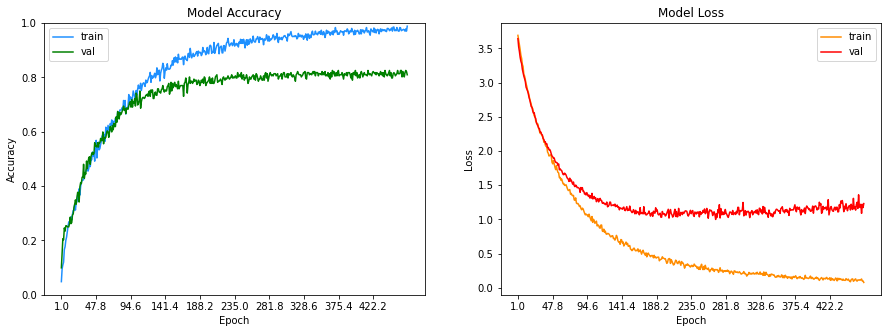

MLP took 802.6427783966064 seconds in training


In [ ]:
plot_model_history(data)
print('MLP took ' + str(end - start) + ' seconds in training')

In [ ]:
start = time()
loss, acc = mlp.evaluate(te_signs, te_labels, verbose=0)
end = time()
print('MLP took ' + str(end - start) + ' seconds')
print('Test loss: ' + str(loss) + ' - Accuracy: ' + str(acc))

MLP took 0.7337398529052734 seconds
Test loss: 0.5650550127029419 - Accuracy: 0.9113573431968689
